### Udacity - Fundamentos de Data Science II
### Projeto 02: Preparar e Analisar Dados

#### Descrição

Este conjunto de dados é o arquivo de tweets do usuário do Twitter @dog_rates, também conhecido como WeRateDogs. WeRateDogs é uma conta no Twitter que classifica os cães das pessoas com um comentário bem humorado sobre o cão. Ele foi iniciado em 2015 pelo estudante universitário Matt Nelson e recebeu cobertura da mídia internacional. Em outubro de 2017 tinha mais 3,7 milhões de seguidores.  
As classificações são do tipo em que um numerador varia de 1 a 10 sobre o denominador 10. Mas os numeradores quase sempre maiores que 10, como 11, 12 ou 13/10. Isso porque, segundo @dog_rates, eles são bons cães.

### Questionamentos

1. Quais os 5 cães que tiveram mais tweets compartilhados e suas classificações do WeRateDogs?
2. Qual a distribuição dos cães segundo os estágios propostos pelo WeRateDogs?
3. A raça dos cães parece ter alguma relação com o compartilhamento dos tweets?
4. Há muitos cães com o mesmo nome? Se sim, quais os 10 nomes mais comuns?
5. O estágio do cão sugere alguma relação com a classificação dada pelo WeRateDogs?

---

### Preparação dos dados

#### Coleta de Dados

- De acordo com a descrição do projeto, seus objetivos e necessidades durante o projeto, optou-se por utilizar este conjunto de bibliotecas.
- Se desejar acompanhar a partir da fase de Exploração e Análise, lá são carregadas as bibliotecas e o conjunto de dados já limpo.

In [1]:
# Importa bibliotecas úteis
from IPython.display import clear_output
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import time
import csv
import ast

- Com a descrição do projeto foi recebido um arquivo de dados pré-extraídos do WeRateDogs: '**twitter-archive-enhanced.csv**'.

In [2]:
# Importa arquivo 'twitter-archive-enhanced.csv' para um dataframe.
df_twi = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Total de linhas importadas.
df_twi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- Também foi disponibilizado um arquivo com dados extraídos através de uma rede neural, sobre a provável raça dos cães classificados pelo WeRateDogs, a ser baixado através da URL:
https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [25]:
# Baixa o arquivo 'image-predictions.tsv'
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join('', url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [4]:
# Importa o arquivo 'image-predictions.tsv' para um dataframe.
df_ima_pre = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
# Total de linhas importadas.
df_ima_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- Além dos dados fornecidos em arquivo, foi feita uma coleta de dados adicional através da API do Twitter.  
Usando o tweet_id de cada linha do dataframe df_twi (tweets), criou-se o arquivo 'tweet_json.txt' contendo os dados JSON de cada tweet.

In [27]:
# Parâmetros para acessar a API do Twitter.
CONSUMER_KEY = ''
CONSUMER_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''

In [28]:
# Autentica conta no Twitter
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [29]:
# Função para exibição de mensagens durante a pausa de leitura dos tweets da API.
def mensagens_leitura_tweets(segundos, num_tweet, num_tweet_erro, tempo):
    print('\nAguardando', segundos, 'segundos...\n')
    print(num_tweet, 'Tweets lidos.')
    print(num_tweet_erro, 'Erros de acesso.\n')
    print('Quando o limite de quantidade de acesso é alcançado é preciso aguardar 15 minutos antes de continuar.')
    print('A cada minuto será exibido o tempo restante para certificar que o código está rodando corretamente.')
    print('O código deverá continuar automaticamente de onde parou. Aguarde!\n')
    print('Faltam menos de', int(segundos - tempo), 'segundos.')

# Função que suspende a execução pelo número de segundo recebidos na entrada.
def aguardar(segundos):
    tempo = 0
    lapso_tempo = 0
    mensagens_leitura_tweets(segundos, num_tweet, num_tweet_erro, tempo)
    start = time.time()
    while tempo <= segundos:
        end = time.time()
        tempo = (end - start)
        if (tempo >= (lapso_tempo + 60)):
            clear_output()
            mensagens_leitura_tweets(segundos, num_tweet, num_tweet_erro, tempo)
            lapso_tempo = tempo
    print('\nContinuando...')

- O processo de leitura de Tweets pela API é demorado.  
Devido a limitação da quantidade de acessos consecutivos imposta pelo Twitter, a cada 180 registros lidos é preciso pausar o processo de leitura e aguardar 15 minutos. Até que a contagem de acessos seja reiniciada pelos servidores do Twittter.

Cálculo do aproximado do tempo total do processo de leitura. Desconsiderado o tempo de resposta na Internet.

In [30]:
# Quantidade de registros a processar
registros = len(df_twi)
# Limite de leituras por vez
rate_limit = 180
# Tempo de espera para reinicialização do contador de leituras no servidor do Twitter
rate_reset_time = 900
# Cálcula do tempo total do processo de leitura.
tempo = ((registros / rate_limit) * ((rate_reset_time / 60) - 1)) / 60
print('O tempo aproximado para execução do processo de leitura é de {:2.2f} horas.'.format(tempo))

O tempo aproximado para execução do processo de leitura é de 3.05 horas.


- Início do processo de leitura

In [31]:
# Lê JSON's tweets e armazena no arquivo 'tweet_json.txt'

tweet_erros = []
num_tweet = 0
num_tweet_erro = 0
json_file = 'tweet_json.txt'

print('Iniciando leitura de Tweets. Aguarde...')

# Abre arquivo 'tweet_json.txt' para escrita
with open(json_file, 'w') as outfile:

# Inicia de leitura dos tweets
    for id_of_tweet in df_twi.tweet_id:
        limite = api.rate_limit_status()
        limite_qty = limite['resources']['application']['/application/rate_limit_status']['remaining']
        if limite_qty >= 2:
            try:
                tweet = api.get_status(id_of_tweet, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            except Exception:
                print('Erro ao tentar acessar o Tweet Id: ', id_of_tweet)
                # Os Tweets Id em que ocorreu algum erro de acesso serão salvos na lista tweet_erros
                tweet_erros.append(id_of_tweet)
                num_tweet_erro += 1
                pass
                continue
            # Grava arquivo JSON dump 'tweet_json.txt'
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            num_tweet += 1
            
            if (num_tweet % 10 == 0):
                clear_output()
                print('Processando...')
                print(num_tweet, 'Tweets lidos.')
                print(num_tweet_erro, 'Erro(s) de acesso.\n')
        else:
            # Chama função para aguardar por 15 minutos e 10 segundos, respeitando o rate_limit do Twitter.
            aguardar(910)
outfile.close()
print('\nLeitura terminada!')
print(num_tweet, 'Tweets lidos.')
if num_tweet_erro > 0:
    # Abre arquivo 'tweet_erros.txt' para escrita
    with open('tweet_erros.txt', 'w') as outfile:
        for reg in tweet_erros:
            outfile.write(str(reg) + '\n')
    outfile.close()
    print('Ocorreram', num_tweet_erro, 'erros de acesso.')
    print('Os Tweets Id que ocasionaram erros de acesso (tweet_erros) foram registrados no arquivo "tweet_erros.txt".')
else:
    print('Tudo Ok! Nenhum erro de acesso.')

Processando...
2330 Tweets lidos.
11 Erro(s) de acesso.


Leitura terminada!
2332 Tweets lidos.
Ocorreram 11 erros de acesso.
Os Tweets Id que ocasionaram erros de acesso (tweet_erros) foram registrados no arquivo "tweet_erros.txt".


- Não foi possível acessar alguns Tweets que estavam no arquivo fornecido ('twitter-archive-enhanced.csv') através da API do Twitter.  
Possivelmente foram apagados ou perdidos após o arquivo fornecido ter sido gravado.

In [5]:
# Tweet Id que não puderam ser acessados através da API d Twitter.
tweet_erros

[888202515573088257,
 873697596434513921,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 845459076796616705,
 842892208864923648,
 837012587749474308,
 827228250799742977,
 802247111496568832,
 775096608509886464]

In [33]:
# Checa os erros ocorrido.
print('Erros retonados ao acessar os Tweet Id que provocaram erro\n')
for tweet_id in tweet_erros:
    try:
        api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    except tweepy.TweepError as e:
        erro = e.reason
        print('Tweet Id:',tweet_id, '/ Cód Erro:', ast.literal_eval(erro[1:-1])['code'],
              '/ Desc:',ast.literal_eval(erro[1:-1])['message'])

Erros retonados ao acessar os Tweet Id que provocaram erro

Tweet Id: 888202515573088257 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 873697596434513921 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 869988702071779329 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 866816280283807744 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 861769973181624320 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 845459076796616705 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 842892208864923648 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 837012587749474308 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 827228250799742977 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 802247111496568832 / Cód Erro: 144 / Desc: No status found with that ID.
Tweet Id: 775096608509886464 / Cód Erro: 144 / Desc: No status found with that ID.


- Foi feita uma comparaçao entre a quantidade total de registros do arquivo fornecido e a quantidade de registros lidos/salvos via API. Deduzida a quantidade de registros com erro de acesso.

In [7]:
# Cria uma lista 'json_data' a partir do arquivo  'tweet_json.txt'
fname = 'tweet_json.txt'
json_data = []
with open(fname, 'r') as f:
    for line in f:
        json_data.append(json.loads(line))
print('Quantidade de registros fornecidos no arquivo "twitter-archive-enhanced.csv":', len(df_twi))
print('Quantidade de registros com erro de acesso:', len(tweet_erros))
print('Quantidade de registros salvos via API do Twitter:', len(json_data))
print('\n(', len(df_twi), '-', len(tweet_erros), ') -', len(json_data), '=',
      (len(df_twi) - len(tweet_erros)) - len(json_data), 'registros.')

Quantidade de registros fornecidos no arquivo "twitter-archive-enhanced.csv": 2356
Quantidade de registros com erro de acesso: 11
Quantidade de registros salvos via API do Twitter: 2345

( 2356 - 11 ) - 2345 = 0 registros.


- Também foi feita uma comparação entre os registros recebidos e salvos via API, filtrando os registros que tiveram erro de acesso.

In [8]:
# Cria lista de Ids de tweets fornecidos via arquivo
tweets_id_fornecidos = df_twi.tweet_id

# Cria lista de Ids de tweets salvos via API.
tweets_id_api = []
for d in json_data:
    tweets_id_api.append(d.get('id'))
    
# Filtra tweets que faltam
faltam = list(set(tweets_id_fornecidos) - set(tweet_erros))
# Calcula tweets que faltam
tweets_faltam = list(set(faltam) - set(tweets_id_api))

print('No arquivo fornecido, "twitter-archive-enhanced.csv", há', len(tweets_faltam), 'Tweets Id\nque não constam no arquivo "tweet_json.txt" criado via API do Twitter.')
tweets_faltam

No arquivo fornecido, "twitter-archive-enhanced.csv", há 0 Tweets Id
que não constam no arquivo "tweet_json.txt" criado via API do Twitter.


[]

- Confirmada a coleta de dados adicionais para todos os Tweets do arquivo 'twitter-archive-enhanced.csv' fornecido. Exceto os com status de inexistentes na base de dados do Twitter. Criou-se um dataframe como informações adicionais para cada um dos Tweets fornecidos.

In [9]:
# Lê json_data e cria a dataframe df_twi_add
tweet_inf_add = []
for tweet in json_data:
    tweet_id = tweet.get('id')
    favorite_count = tweet.get('favorite_count')
    retweet_count = tweet.get('retweet_count')
    tweet_inf_add.append([tweet_id, favorite_count, retweet_count])

labels = ['tweet_id', 'favorite_count', 'retweet_count']
df_twi_add = pd.DataFrame.from_records(tweet_inf_add, columns=labels)

In [10]:
df_twi_add.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,38854,8609
1,892177421306343426,33281,6322
2,891815181378084864,25076,4194
3,891689557279858688,42240,8721
4,891327558926688256,40380,9489


#### Avaliação dos Dados

##### Qualidade

Dataframe de Tweets - **df_twi**  
- Tem mais linhas que o do dataframe de informações adicionais **df_twi_add**. Devido aos registros não encontrados via API do Twitter.
- Na coluna **in_reply_to_status_id** existem 2278 valores nulos.
- Na coluna **in_reply_to_user_id** existem 2278 valores nulos.
- Na coluna **retweeted_status_id** existem 2175 valores nulos.
- Na coluna **retweeted_status_user_id** existem 2175 valores nulos.
- Na coluna **retweeted_status_timestamp** existem 2175 valores nulos.
- Na coluna **expanded_urls** existem 59 valores nulos.
- As colunas 'doggo', 'floofer', 'pupper' e 'puppo', embora não estejam com valores 'NaN', há valores com a string 'None'.
- Na coluna 'name', embora não hajam valores 'NaN', há valores com a string 'None' e valores que não parecem nomes como: 'a', 'actually' e 'just'. Nomes e o valor 'None' começam por letras maiúsculas, os valores que não são nomes nem 'None' estão com letras minúsculas.
- Na coluna **rating_denominator** há denominadores diferentes de 10. Aparentemente a extração da classificação do cão feita sobre o campo texto, buscava trechos de strings que tivessem o caractér '/' e acabou pegando uma string com '/' que não era uma classificação. Provavelmente o valor em **rating_numerator** também está errado.
- Na coluna **text**, é possível ver vários textos com 'RT' no início que são retweets, informação repetida.

Dataframe de predições de raça por imagem **df_ima_pre**

- Tem menos linhas que os dataframes **df_twi** e **df_twi_add**.
- Os nomes das raças estão despadronizados, alguns em maiúsculas, outros em minúsculas e com as palavras separadas por 'underline' ao invés de espaço.

Dataframe de dados limpos **df_tweets**

- Durante o processo de análise optou-se por utilizar os valores da colunas **breed_predition_01** por ter maior índice de certeza de predição, de acordo com coluna **reliability_percent_01**. Porém, mesmo as linhas que tem 100% (1.0) na coluna **reliability_percent_01**, possuem valores na coluna **breed_predition_01** que não são nomes de raça. Porque o algorítimo de predição deu o nome para algo que identificou na foto e não da raça do cão.

##### Arrumação
- Há dados sobre os mesmos Tweets em 3 dataframes diferentes.
- De acordo com valores de classificação dos cães percebidos na coluna **texto**, a coluna **rating_numerator** pode necessitar armazenar valores do tipo **float**.
- No dataframe **df_twi**, as colunas **doggo**, **floofer**, **pupper** e **puppo**, deveriam ser valores em uma coluna de estágios de cães.
- No dataframe **df_ima_pre** colunas **p1**, **p1_conf**, **p1_dog**, **p2**, **p2_conf**, **p2_dog**, **p3**, **p3_conf** e **p3_dog** poderiam ter nomes mais descritivos.

*Foram feitas várias observações de dados*

In [11]:
df_twi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
df_twi.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
842,766793450729734144,NaN,NaN,2016-08-20 00:26:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rufus. He just missed out on the 100m ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766793450...,10,10,Rufus,None,None,None,None
2002,672481316919734272,NaN,NaN,2015-12-03 18:23:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Jazz. She should be on the cover ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672481316...,12,10,Jazz,None,None,pupper,None
835,768193404517830656,NaN,NaN,2016-08-23 21:09:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Gerald. He's a fairly exotic doggo. Floof...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768193404...,8,10,Gerald,doggo,None,None,None
1484,693231807727280129,NaN,NaN,2016-01-30 00:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Bodie. He's not proud of what he did, ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/693231807...,9,10,Bodie,None,None,None,None


In [13]:
df_twi.in_reply_to_status_id.isnull().value_counts()

True     2278
False      78
Name: in_reply_to_status_id, dtype: int64

In [14]:
df_twi.in_reply_to_user_id.isnull().value_counts()

True     2278
False      78
Name: in_reply_to_user_id, dtype: int64

In [15]:
df_twi.retweeted_status_id.isnull().value_counts()

True     2175
False     181
Name: retweeted_status_id, dtype: int64

In [16]:
df_twi.retweeted_status_user_id.isnull().value_counts()

True     2175
False     181
Name: retweeted_status_user_id, dtype: int64

In [17]:
df_twi.retweeted_status_timestamp.isnull().value_counts()

True     2175
False     181
Name: retweeted_status_timestamp, dtype: int64

In [18]:
df_twi.expanded_urls.isnull().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

In [19]:
# Valores que não parecem nomes
no_names =[]
for t in df_twi['name']:
    if t.islower():
        no_names.append(t)
print(no_names)

['such', 'a', 'quite', 'quite', 'quite', 'not', 'one', 'incredibly', 'a', 'mad', 'an', 'very', 'a', 'very', 'just', 'my', 'one', 'not', 'his', 'one', 'a', 'a', 'a', 'an', 'very', 'actually', 'a', 'just', 'getting', 'mad', 'very', 'this', 'unacceptable', 'all', 'a', 'old', 'a', 'infuriating', 'a', 'a', 'a', 'an', 'a', 'a', 'very', 'getting', 'just', 'a', 'the', 'the', 'actually', 'by', 'a', 'officially', 'a', 'the', 'the', 'a', 'a', 'a', 'a', 'life', 'a', 'one', 'a', 'a', 'a', 'light', 'just', 'space', 'a', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'an', 'a', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'quite', 'a', 'an', 'a', 'an', 'the', 'the', 'a', 'a', 'an', 'a', 'a', 'a', 'a']


In [20]:
df_twi_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
favorite_count    2345 non-null int64
retweet_count     2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [21]:
df_ima_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_ima_pre.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1680,813800681631023104,https://pbs.twimg.com/media/C0szZh_XUAAm9je.jpg,1,malamute,0.501159,True,Siberian_husky,0.228792,True,Eskimo_dog,0.200388,True
433,674318007229923329,https://pbs.twimg.com/media/CVuopr8WwAExw_T.jpg,1,porcupine,0.846628,False,hamster,0.038136,False,echidna,0.014680,False
458,674788554665512960,https://pbs.twimg.com/media/CV1Um8vWIAAmhQn.jpg,1,miniature_poodle,0.349561,True,toy_poodle,0.154711,True,Maltese_dog,0.134229,True
1815,833826103416520705,https://pbs.twimg.com/media/C5JYaYoVYAAcEQw.jpg,1,Chihuahua,0.438054,True,kelpie,0.149706,True,Pembroke,0.096480,True
1453,776819012571455488,https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg,3,Chihuahua,0.346545,True,dalmatian,0.166246,True,toy_terrier,0.117502,True
813,692535307825213440,https://pbs.twimg.com/media/CZxhL2yWAAI_DHn.jpg,1,pug,0.413090,True,French_bulldog,0.199865,True,Chihuahua,0.081991,True
1636,806242860592926720,https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg,2,Cardigan,0.593858,True,Shetland_sheepdog,0.130611,True,Pembroke,0.100842,True
1782,828770345708580865,https://pbs.twimg.com/media/C4BiOXOXAAAf6IS.jpg,1,seat_belt,0.765979,False,Chesapeake_Bay_retriever,0.033899,True,polecat,0.027252,False
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
695,684460069371654144,https://pbs.twimg.com/media/CX-wzZEUwAA4ISM.jpg,1,Labrador_retriever,0.673691,True,Chesapeake_Bay_retriever,0.194897,True,American_Staffordshire_terrier,0.059471,True


---

### Limpeza de Dados

##### Limpeza 01
O dataframe **df_twi** tem mais linhas que o do dataframe de informações adicionais **df_twi_add**. Devido aos registros não encontrados via API do Twitter.
#### Definição
- Descartar as linhas do dataframes **df_twi** referentes aos Tweets não encontrados via API do Twitter.

##### Codificação

In [23]:
# Faz uma cópia do dataframe
df_twi_v1 = df_twi.copy()

# Remove linhas do dataframe df_twi referentes aos Tweets não encontrados via API do Twitter.
for t_id in tweet_erros:
    df_twi.drop(df_twi.index[df_twi['tweet_id'] == t_id], inplace = True)

##### Teste

In [24]:
# Verifica a quantidade de linhas.
len(df_twi_add)

2345

In [25]:
# Verifica a quantidade de linhas.
len(df_twi)

2345

---

##### Limpeza 02
O dataframe **df_ima_pre** tem menos linhas que os dataframes **df_twi** e **df_twi_add**.
#### Definição
- Descartar as linhas dos dataframes **df_twi** e **df_twi_add** que não tiverem Tweet Id correpondente no dataframe **df_ima_pre**.
- Descartar as linhas do dataframe **df_ima_pre** referentes aos Tweets não encontrados via API do Twitter.

##### Codificação

In [26]:
# Faz uma cópia do dataframe
df_twi_v2 = df_twi.copy()

# Remove linhas do dataframe df_twi que não tenham Tweet Id correspondente em df_ima_pre
for t_id in df_twi.tweet_id:
    if (any(df_ima_pre.tweet_id == t_id)):
        a = 1
    else:
        df_twi.drop(df_twi.index[df_twi['tweet_id'] == t_id], inplace = True)

In [27]:
# Faz uma cópia dataframe
df_twi_add_v1 = df_twi_add.copy()

# Remove linhas do dataframe df_twi_add que não tenham Tweet Id correspondente em df_ima_pre
for t_id in df_twi_add.tweet_id:
    if (any(df_ima_pre.tweet_id == t_id)):
        a = 1
    else:
        df_twi_add.drop(df_twi_add.index[df_twi_add['tweet_id'] == t_id], inplace = True)

In [28]:
# Faz uma cópia dataframe
df_ima_pre_v1 = df_ima_pre.copy()

# Remove linhas do dataframe df_ima_pre referentes aos Tweets não encontrados via API do Twitter.
for t_id in tweet_erros:
    df_ima_pre.drop(df_ima_pre.index[df_ima_pre['tweet_id'] == t_id], inplace = True)

##### Teste

In [29]:
# Verifica a quantidade de linhas.
len(df_twi)

2069

In [30]:
# Verifica a quantidade de linhas.
len(df_twi_add)

2069

In [31]:
# Verifica a quantidade de linhas.
len(df_ima_pre)

2069

---

##### Limpeza 03

No dataframe de Tweets **df_twi**   
Na coluna **in_reply_to_status_id** existem 2278 valores nulos.  
Na coluna **in_reply_to_user_id** existem 2278 valores nulos.  
Na coluna **retweeted_status_id** existem 2175 valores nulos.  
Na coluna **retweeted_status_user_id** existem 2175 valores nulos.  
Na coluna **retweeted_status_timestamp** existem 2175 valores nulos.  
Na coluna **expanded_urls** existem 59 valores nulos.
#### Definição
- Descartar as colunas.

##### Codificação

In [32]:
# Faz uma cópia do dataframe
df_twi_v3 = df_twi.copy()

# Descarta colunas
df_twi.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
             'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace = True)

##### Teste

In [33]:
df_twi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2069 non-null int64
timestamp             2069 non-null object
source                2069 non-null object
text                  2069 non-null object
rating_numerator      2069 non-null int64
rating_denominator    2069 non-null int64
name                  2069 non-null object
doggo                 2069 non-null object
floofer               2069 non-null object
pupper                2069 non-null object
puppo                 2069 non-null object
dtypes: int64(3), object(8)
memory usage: 194.0+ KB


---

##### Limpeza 04

Há dados sobre os mesmos Tweets em 3 dataframes diferentes.
#### Definição
- Unir as colunas dos 3 dataframes **df_twi**, **df_twi_add** e **df_ima_pre** em um novo dataframe.

##### Codificação

In [34]:
# Une as colunas do dataframe df_twi com as do dataframe df_twi_add em um dataframe intermediário df_result.
df_result = pd.merge(df_twi, df_twi_add, on='tweet_id')

In [35]:
# Une as colunas do dataframe df_result com as do dataframe df_ima_pre no dataframe final df_tweets.
df_tweets = pd.merge(df_result, df_ima_pre, on='tweet_id')

##### Teste

In [36]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2068
Data columns (total 24 columns):
tweet_id              2069 non-null int64
timestamp             2069 non-null object
source                2069 non-null object
text                  2069 non-null object
rating_numerator      2069 non-null int64
rating_denominator    2069 non-null int64
name                  2069 non-null object
doggo                 2069 non-null object
floofer               2069 non-null object
pupper                2069 non-null object
puppo                 2069 non-null object
favorite_count        2069 non-null int64
retweet_count         2069 non-null int64
jpg_url               2069 non-null object
img_num               2069 non-null int64
p1                    2069 non-null object
p1_conf               2069 non-null float64
p1_dog                2069 non-null bool
p2                    2069 non-null object
p2_conf               2069 non-null float64
p2_dog                2069 non-null boo

---

##### Limpeza 05

No dataframe **df_twi**, as colunas **doggo**, **floofer**, **pupper** e **puppo**, deveriam ser valores em uma coluna de estágios de cães.
#### Definição
No novo dataframe **df_tweets**:
- Quando os valores da coluna **floofer** forem igual a 'floofer', atribuir 'floofer' ao valor da coluna **doggo**.
- Quando os valores da coluna **pupper** forem igual a 'pupper', atribuir 'pupper' ao valor da coluna **doggo**.
- Quando os valores da coluna **puppo** forem igual a 'puppo', atribuir 'puppo' ao valor da coluna **doggo**.
- Renomear a coluna **doggo** para **dog_stage**.
- Descartar as colunas **floofer**, **pupper**, **puppo**.


##### Codificação

In [57]:
# Faz uma cópia do dataframe
df_tweets_v1 = df_tweets.copy()

for row in df_tweets.iterrows():
    dog_stage = ''
    if row[1]['doggo'] != 'None':
        dog_stage = row[1]['doggo']
    if row[1]['floofer'] != 'None':
        if dog_stage == '':
            dog_stage = row[1]['floofer']
        else:
            dog_stage = dog_stage + ',' + row[1]['floofer']
    if row[1]['pupper'] != 'None':
        if dog_stage == '':
            dog_stage = row[1]['pupper']
        else:
            dog_stage = dog_stage + ',' + row[1]['pupper']
    if row[1]['puppo'] != 'None':
        if dog_stage == '':
            dog_stage = row[1]['puppo']
        else:
            dog_stage = dog_stage + ',' + row[1]['puppo']
    df_tweets.loc[df_tweets['tweet_id'] == row[1]['tweet_id'], 'doggo'] = dog_stage

In [73]:
# Renomear a coluna doggo para dog_stage.
df_tweets = df_tweets.rename(columns={'doggo': 'dog_stage'})

In [74]:
# Descartar as colunas floofer, pupper, puppo.
df_tweets.drop(['floofer', 'pupper', 'puppo'], axis=1, inplace = True)

##### Teste

In [75]:
df_tweets.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1636,674291837063053312,2015-12-08 18:17:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kenny. He just wants to be included in...,11,10,Kenny,,15464,6332,...,1,Cardigan,0.611525,True,Pembroke,0.368566,True,Chihuahua,0.003330,True
615,776819012571455488,2016-09-16 16:24:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody look at this beautifu...,13,10,None,pupper,0,15401,...,3,Chihuahua,0.346545,True,dalmatian,0.166246,True,toy_terrier,0.117502,True
1989,667453023279554560,2015-11-19 21:22:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Cupcake. I would do unspeakable things fo...,11,10,Cupcake,,320,93,...,1,Labrador_retriever,0.825670,True,French_bulldog,0.056639,True,Staffordshire_bullterrier,0.054018,True
311,825535076884762624,2017-01-29 02:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very loving and accepting puppo. Appe...,14,10,None,puppo,56264,19221,...,1,Rottweiler,0.681495,True,Tibetan_mastiff,0.147940,True,black-and-tan_coonhound,0.024525,True
288,828708714936930305,2017-02-06 20:55:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fiona. She's an exotic dog. Seems rath...,10,10,Fiona,,39484,12501,...,1,hippopotamus,0.942911,False,Mexican_hairless,0.008388,True,ice_lolly,0.006206,False


In [76]:
df_tweets.dog_stage.value_counts()

                 1748
pupper            211
doggo              67
puppo              23
doggo,pupper       11
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: dog_stage, dtype: int64

---

##### Limpeza 06

No dataframe **df_twi**, a coluna **name**, embora não hajam valores 'NaN', há valores com a string 'None' e valores que não parecem nomes como: 'a', 'actually' e 'just'. Nomes e o valor 'None' começam por letras maiúsculas, os valores que não são nomes nem 'None' estão com letras minúsculas.
#### Definição
No novo dataframe **df_tweets**:
- Na coluna **name**, do novo dataframe **df_tweets**, mudar as palavras que não são nomes (em minúsculas) para 'None'.


##### Codificação

In [77]:
# Faz uma cópia do dataframe
df_tweets_v2 = df_tweets.copy()

# Muda na coluna 'name' as strings minúsculas para 'None'
for t in df_tweets['name']:
    if t.islower():
        df_tweets.loc[df_tweets['name'] == t, 'name'] = 'None'

##### Teste

In [78]:
for t in df_tweets['name']:
    if t.islower():
        print(t)

---

##### Limpeza 07

De acordo com valores de classificação dos cães percebidos na coluna **texto**, a coluna **rating_numerator** pode necessitar armazenar valores do tipo **float**.
#### Definição
No novo dataframe **df_tweets**:
- Mudar o tipo de dados da coluna para **float**.

##### Codificação

In [79]:
# Faz uma cópia do dataframe
df_tweets_v3 = df_tweets.copy()

# Modifica o tipo de dado para float.
df_tweets['rating_numerator'] = df_tweets['rating_numerator'].astype(float)

##### Teste

In [80]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2068
Data columns (total 21 columns):
tweet_id              2069 non-null int64
timestamp             2069 non-null object
source                2069 non-null object
text                  2069 non-null object
rating_numerator      2069 non-null float64
rating_denominator    2069 non-null int64
name                  2069 non-null object
dog_stage             2069 non-null object
favorite_count        2069 non-null int64
retweet_count         2069 non-null int64
jpg_url               2069 non-null object
img_num               2069 non-null int64
p1                    2069 non-null object
p1_conf               2069 non-null float64
p1_dog                2069 non-null bool
p2                    2069 non-null object
p2_conf               2069 non-null float64
p2_dog                2069 non-null bool
p3                    2069 non-null object
p3_conf               2069 non-null float64
p3_dog                2069 non-null bo

---

##### Limpeza 08

No dataframe **df_twi**, a coluna **rating_denominator** há valores diferentes de 10. Aparentemente a extração da classificação do cão feita sobre o campo texto, buscava trechos de strings que tivessem o caractér '/' e acabou pegando uma string com '/' que não era uma classificação. Provavelmente o valor em **rating_numerator** também está errado.
#### Definição
No novo dataframe **df_tweets**:
- Rafazer a busca das classificações e armazenar os valores nas coluna **rating_numerator** e **rating_denominator**, verificando o conteúdo na coluna **text**. Caso haja em **text** substring com padrão 'nn/10', onde 'nn' é um número de 0 a 99, salvar os valores antes e depois do caractér '/' nas colunas **rating_numerator** e **rating_denominator**, respectivamente.

##### Codificação

In [81]:
# Faz uma cópia do dataframe
df_tweets_v4 = df_tweets.copy()

# Busca classificações na coluna 'texto' e armazena nas colunas 'rating_numerator' e 'rating_denominator'.
valid_char = '0123456789'
for rt in df_tweets['text']:
    if '/10' in rt:
        pos = rt.find('/10')
        value = ''
        for i in range(pos-5, pos):
            char = rt[i]
            if (i == pos - 5) and (char in valid_char) and (rt[pos - 4] in valid_char):
                value = value + char
            elif (i == pos - 4) and (char in valid_char):
                value = value + char
            elif (i == pos - 3) and (char in valid_char or (char == '.' and rt[pos - 4] in valid_char)) and (rt[pos - 2] in valid_char or rt[pos - 2] == '.'):
                value = value + char
            elif (i >= pos - 2) and (char in valid_char or char == '.'):
                value = value + char
        if value[0] == '.':
            value = value[1:len(value)]
        
        # Armazena os valores nas colunas
        df_tweets.loc[df_tweets['text'] == rt, 'rating_numerator'] = float(value)
        df_tweets.loc[df_tweets['text'] == rt, 'rating_denominator'] = 10

##### Teste

In [82]:
df_tweets.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
282,829501995190984704,2017-02-09 01:27:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He was a skater pup. She said see...,12.0,10,Leo,,34203,11808,...,1,French_bulldog,0.950851,True,Pekinese,0.015200,True,pug,0.011094,True
70,877201837425926144,2017-06-20 16:29:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nelly. He graduated with his dogtorate...,12.0,10,Nelly,,27212,5680,...,1,Pembroke,0.931120,True,Cardigan,0.068698,True,basenji,0.000082,True
1062,709158332880297985,2016-03-13 23:24:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rodney. He's a Ukranian Boomchicka. Outsi...,10.0,10,Rodney,,2188,454,...,1,Siberian_husky,0.212957,True,Eskimo_dog,0.178887,True,Labrador_retriever,0.174218,True
732,758355060040593408,2016-07-27 17:35:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Corey. He's a Portobello Corgicool. Tr...,11.0,10,Corey,,3719,1206,...,1,Pembroke,0.987643,True,Cardigan,0.012112,True,Siamese_cat,0.000117,False
1514,677644091929329666,2015-12-18 00:18:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a dog swinging. I really enjoyed it so...,11.0,10,None,,1995,870,...,1,Chihuahua,0.626236,True,Italian_greyhound,0.128483,True,swing,0.059840,False


----

##### Limpeza 09

Na dataframe **df_twi**, na coluna **text**, é possível ver vários textos com 'RT' no início que são retweets, ou seja, informação repetida.

#### Definição
No novo dataframe **df_tweets**:
- Remover as linhas onde os valores da coluna **text** iniciem com as string 'RT'.


##### Codificação

In [83]:
# Faz uma cópia do dataframe
df_tweets_v5 = df_tweets.copy()

# Remove as linhas em que a string na coluna 'text' começam com RT
for t in df_tweets.text:
    if t[0:2] == 'RT':
        df_tweets = df_tweets.drop(df_tweets[df_tweets.text == t].index)

##### Teste

In [84]:
for r in df_tweets.text:
    if r[0:2] == 'RT':
        print(r)

---

##### Limpeza 10

Dataframe de predições de raça por imagem **df_ima_pre**, os nomes das raças estão despadronizados, alguns em maiúsculas, outros em minúsculas e com as palavras separadas por 'underline' ao invés de espaço.
#### Definição
No novo dataframe **df_tweets**:
- Remover os 'underlines' e mudar a primeira letra das palavras para maiúscula.


##### Codificação

In [85]:
# Faz uma cópia do dataframe
df_tweets_v6 = df_tweets.copy()

# Troca 'undeline' por espaço na coluna P1
for t in df_tweets['p1']:
    df_tweets.loc[df_tweets['p1'] == t, 'p1'] = t.replace("_", " ").title()

In [86]:
# Troca 'undeline' por espaço na coluna P2
for t in df_tweets['p2']:
    df_tweets.loc[df_tweets['p2'] == t, 'p2'] = t.replace("_", " ").title()

In [87]:
# Troca 'undeline' por espaço na coluna P3
for t in df_tweets['p3']:
    df_tweets.loc[df_tweets['p3'] == t, 'p3'] = t.replace("_", " ").title()

##### Teste

In [88]:
df_tweets.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1391,683481228088049664,2016-01-03 02:53:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Banjo. He's a Peppercorn Shoop Da Whoop. ...,11.0,10,Banjo,pupper,2820,1088,...,1,Keeshond,0.508951,True,Chow,0.442016,True,German Shepherd,0.013206,True
1774,671355857343524864,2015-11-30 15:51:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lou. He's a Petrarch Sunni Pinto. Well...,10.0,10,Lou,,496,118,...,1,Miniature Poodle,0.313811,True,Toy Poodle,0.165585,True,Irish Terrier,0.056094,True
213,841680585030541313,2017-03-14 16:01:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's a dragon slayer. Feared b...,12.0,10,Penny,,27305,8495,...,1,Chihuahua,0.547401,True,Bow Tie,0.198361,False,Pembroke,0.058493,True
1340,686386521809772549,2016-01-11 03:17:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Crimson. He's a Speckled Winnebag...,11.0,10,Crimson,,3483,975,...,1,Yorkshire Terrier,0.477704,True,Silky Terrier,0.171673,True,Australian Terrier,0.088334,True
30,885984800019947520,2017-07-14 22:10:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion advised. This is Jimbo. He w...,12.0,10,Jimbo,,32771,6873,...,1,Blenheim Spaniel,0.972494,True,Shih-Tzu,0.006630,True,Bernese Mountain Dog,0.006239,True


---

##### Limpeza 11

No dataframe **df_ima_pre** colunas **p1**, **p1_conf**, **p1_dog**, **p2**, **p2_conf**, **p2_dog**, **p3**, **p3_conf** e **p3_dog** poderiam ter nomes mais descritivos.
#### Definição
No novo dataframe **df_tweets**, renomear as colunas:  
- p1 para 'prediction_01, p1_conf para reliability_percent_01, p1_dog para is_a_dog_01
- p2 para 'prediction_02, p2_conf para reliability_percent_02, p2_dog para is_a_dog_02
- p3 para 'prediction_03, p3_conf para reliability_percent_03, p3_dog para is_a_dog_03


##### Codificação

In [89]:
# Faz uma cópia do dataframe
df_tweets_v7 = df_tweets.copy()

# Renomear as colunas referentes a previsão 1.
df_tweets = df_tweets.rename(columns={'p1': 'breed_prediction_01', 'p1_conf': 'reliability_01', 'p1_dog': 'is_a_dog_01'})

# Renomear as colunas referentes a previsão 1.
df_tweets = df_tweets.rename(columns={'p2': 'breed_prediction_02', 'p2_conf': 'reliability_02', 'p2_dog': 'is_a_dog_02'})

# Renomear as colunas referentes a previsão 1.
df_tweets = df_tweets.rename(columns={'p3': 'breed_prediction_03', 'p3_conf': 'reliability_03', 'p3_dog': 'is_a_dog_03'})

##### Teste

In [90]:
df_tweets.sample(1)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,...,img_num,breed_prediction_01,reliability_01,is_a_dog_01,breed_prediction_02,reliability_02,is_a_dog_02,breed_prediction_03,reliability_03,is_a_dog_03
1687,673317986296586240,2015-12-06 01:48:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Take a moment and appreciate how these two dog...,10.0,10,None,,902,281,...,2,Miniature Pinscher,0.384099,True,Bloodhound,0.079923,True,Rottweiler,0.068594,True


---

##### Limpeza 12

No dataframe **df_tweets**, durante a análise optou-se por utilizar os valores da colunas **breed_prediction_01** por ter maior índice de certeza de predição, de acordo com coluna **reliability_percent_01**.  
Porém, mesmo as linhas que tem 100% (1.0) na coluna **reliability_percent_01**, possuem valores na coluna **breed_prediction_01** que não são nomes de raça. Porque o algorítimo de predição deu o nome para algo que identificou na foto e não da raça do cão.
#### Definição
- Utilizar uma lista de raças de cães reconhecidas pelo Amereican Kennel Club e lista obtida no site Kaggle, para identificar os valores válidos na coluna **breed_prediction_01**. Os valores que não estiverem nas listas devem ser alterados como 'indefinite'.


##### Codificação

In [91]:
# Faz uma cópia do dataframe
df_tweets_v8 = df_tweets.copy()

# Carrega lsita de raças em dataframes
df_akc = pd.read_csv('breed_list_akc.csv', sep='\t')
df_kaggle = pd.read_csv('breed_list_kaggle.csv', sep='\t')

# Converte dataframes em listas
breeds_akc = df_akc.breed.tolist()
breeds_kaggle = df_kaggle.breed.tolist()

In [92]:
# Filtra e altera raças na coluna 'breed_prediction_01'
for t in df_tweets['breed_prediction_01']:
    if (t not in breeds_akc and t not in breeds_kaggle):
        df_tweets.loc[df_tweets['breed_prediction_01'] == t, 'breed_prediction_01'] = 'indefinite'

##### Teste

In [93]:
df_tweets.breed_prediction_01.value_counts()

indefinite                     506
Golden Retriever               139
Labrador Retriever              95
Pembroke                        88
Chihuahua                       79
Pug                             54
Chow                            41
Samoyed                         40
Pomeranian                      38
Toy Poodle                      38
Malamute                        29
Cocker Spaniel                  27
French Bulldog                  26
Chesapeake Bay Retriever        23
Miniature Pinscher              22
Siberian Husky                  20
German Shepherd                 20
Staffordshire Bullterrier       19
Shetland Sheepdog               18
Maltese Dog                     18
Eskimo Dog                      18
Rottweiler                      17
Beagle                          17
Cardigan                        17
Shih-Tzu                        17
Italian Greyhound               16
Lakeland Terrier                16
Kuvasz                          16
Great Pyrenees      

- Após o processo de limpeza dataframe foi salvo no arquivo **twitter_archive_master.csv**.

In [94]:
# Salva o dataframe 'df_tweets' no arquivo CSV 'tweets_clean.csv'.
df_tweets.to_csv('twitter_archive_master.csv', sep='\t', encoding='utf-8', index=False)

---

### Exploração dos dados

- Importação do conjunto de dados limpos e das bibliotecas úteis para exploração e análise.

In [95]:
# Importa bibliotecas úteis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Importa o conjunto de dados limpos
df = pd.read_csv('twitter_archive_master.csv', sep='\t')

- A quatidade de linhas confere com a quantidade de registros esperada no conjunto de dados.

In [96]:
# Verifica a quantidade de linhas e colunas.
print(df.shape)

(1993, 21)


- Início da observação dos dados para responder aos questionamento.

In [97]:
df.sample(20)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,...,img_num,breed_prediction_01,reliability_01,is_a_dog_01,breed_prediction_02,reliability_02,is_a_dog_02,breed_prediction_03,reliability_03,is_a_dog_03
1536,674788554665512960,2015-12-10 03:11:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Maggie. She's a Western Septic Do...,9.0,10,Maggie,NaN,847,223,...,1,Miniature Poodle,0.349561,True,Toy Poodle,0.154711,True,Maltese Dog,0.134229,True
962,711694788429553666,2016-03-20 23:23:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh. My. God. 13/10 magical af https://t.co/Ezu...,13.0,10,None,NaN,35120,19960,...,1,indefinite,0.713293,False,Indian Elephant,0.172844,False,Water Buffalo,0.038902,False
310,822859134160621569,2017-01-21 17:31:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hobbes. He was told he was going to th...,12.0,10,Hobbes,NaN,14308,2557,...,1,Malinois,0.332897,True,Chihuahua,0.104116,True,Staffordshire Bullterrier,0.047745,True
1400,679511351870550016,2015-12-23 03:58:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to William. He makes fun of others b...,7.0,10,William,NaN,3605,1415,...,1,Chihuahua,0.761972,True,Black-Footed Ferret,0.150605,False,Squirrel Monkey,0.028148,False
727,749774190421639168,2016-07-04 01:17:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She's a Benebop Cumberplop. 12/1...,12.0,10,Lucy,NaN,5022,1451,...,1,Pekinese,0.879012,True,Chihuahua,0.054855,True,Blenheim Spaniel,0.021041,True
932,715360349751484417,2016-03-31 02:09:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bertson. He just wants to say hi. 11/1...,11.0,10,Bertson,NaN,5841,1717,...,1,indefinite,0.855552,False,Screw,0.073277,False,Padlock,0.023970,False
1082,700864154249383937,2016-02-20 02:06:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Pupper is a present to world. Here is a bow f...",12.0,10,None,pupper,2779,669,...,1,Kuvasz,0.805857,True,Great Pyrenees,0.187272,True,Samoyed,0.003491,True
732,749064354620928000,2016-07-02 02:17:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's pupset because I forgot to ...,11.0,10,Winston,NaN,5179,1676,...,2,Pug,0.985222,True,Brabancon Griffon,0.003314,True,Pekinese,0.002989,True
1017,707059547140169728,2016-03-08 04:25:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Cupcake. She's an Icelandic Dippe...,11.0,10,Cupcake,NaN,2755,741,...,1,Samoyed,0.897312,True,Great Pyrenees,0.039180,True,Kuvasz,0.019516,True
285,827600520311402496,2017-02-03 19:31:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Tucker. It's his birthday. He's pupset wi...,13.0,10,Tucker,NaN,8011,1054,...,1,Pembroke,0.325638,True,Golden Retriever,0.317235,True,Labrador Retriever,0.116087,True


In [98]:
df['rating_numerator'].describe()

count    1993.000000
mean       16.797180
std       197.357392
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      8612.000000
Name: rating_numerator, dtype: float64

In [99]:
df['favorite_count'].describe()

count      1993.000000
mean       8867.045158
std       12585.852053
min          79.000000
25%        1945.000000
50%        4057.000000
75%       11167.000000
max      143576.000000
Name: favorite_count, dtype: float64

In [100]:
df['retweet_count'].describe()

count     1993.000000
mean      2723.280482
std       4701.183848
min         13.000000
25%        608.000000
50%       1316.000000
75%       3128.000000
max      77476.000000
Name: retweet_count, dtype: float64

In [101]:
df.query('name != "None"')['name'].value_counts()[0:10]

Charlie    11
Oliver     10
Cooper     10
Lucy       10
Penny       9
Tucker      9
Sadie       8
Winston     8
Lola        7
Daisy       7
Name: name, dtype: int64

In [102]:
df.query('dog_stage != "None"')['dog_stage'].value_counts()[0:10]

pupper           203
doggo             63
puppo             22
doggo,pupper       9
floofer            7
doggo,floofer      1
doggo,puppo        1
Name: dog_stage, dtype: int64

In [103]:
df.reliability_01.mean()

0.594168880883091

In [104]:
df.reliability_02.mean()

0.13442736860818505

In [105]:
df.reliability_03.mean()

0.060231566735861046

---

### Questão 1
**Quais os 5 cães que tiveram mais retweets, suas classificações do WeRateDogs e quantidade de marcações como favoritos?**

- Foram filtradas as linhas nas quais os cães não tem nomes disponíveis.  
- As linhas foram agrupadas por nome, por raça (minimizando a possibilidade cãe com mesmo nome), rate e quantidade de marcações como favorito. Obtendo-se o somatório de retweets, que foi ordenado descendentemente.
- Resultando em um dataframe com os cães com mais retweets, onde a exibiação foi limitada em 5 linhas pelo padrão do método head().

In [106]:
# Faz uma seleção de dados
dogs_retweets = df.query('name != "None"').groupby(['name','breed_prediction_01','rating_numerator','favorite_count'])['retweet_count'].sum().sort_values(ascending = False).reset_index()
dogs_retweets.head()

,name,breed_prediction_01,rating_numerator,favorite_count,retweet_count
0,Stephan,Chihuahua,13.0,123156,61224
1,Duddles,English Springer,13.0,106131,44686
2,Bo,Standard Poodle,14.0,93798,41075
3,Jamesy,French Bulldog,13.0,124562,36569
4,Kenneth,indefinite,10.0,79140,33754


- A partir das cinco primeiras 5 linhas do dataframe gerado foram plotados os gráficos abaixo.

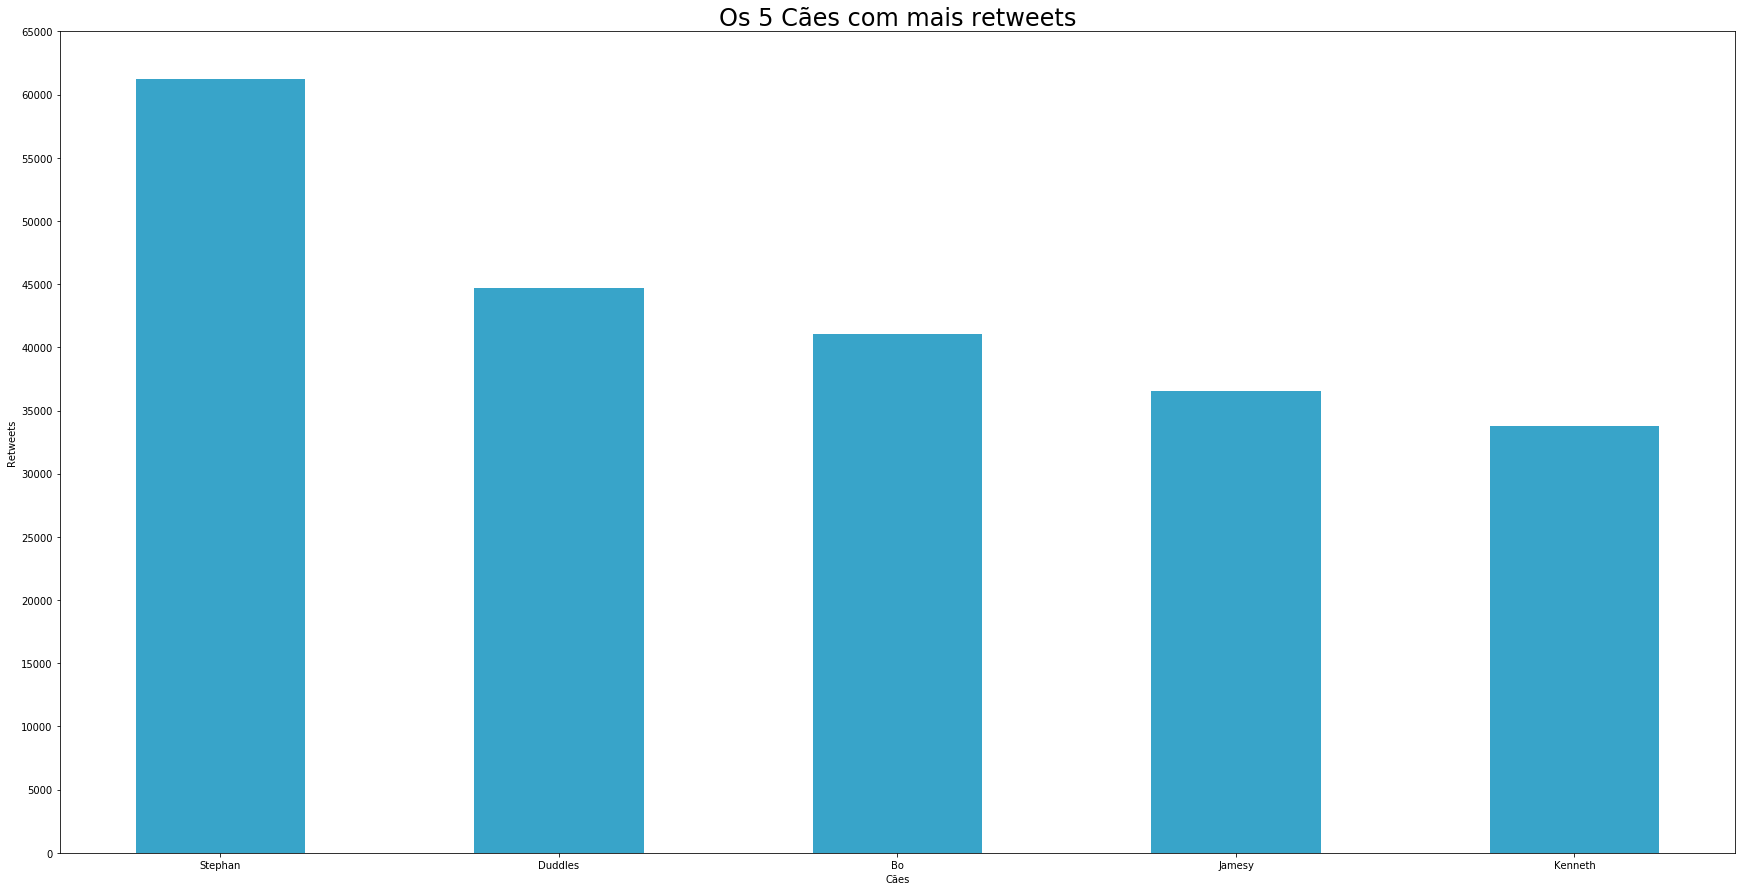

In [107]:
# Cria o gráfico
groups = 5
fig, ax = plt.subplots(figsize=(24, 12))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 1

# Plota gráfico 1
#plt.subplot(1, 3, 1)
plt.rcParams['font.size'] = 20
#plt.tight_layout()
plt.title('Os 5 Cães com mais retweets')
plt.xlabel('Cães')
plt.ylabel('Retweets')
plt.xticks(index, dogs_retweets.name[0:5])
plt.bar(index, dogs_retweets.retweet_count[0:5], bar_width, alpha=transp, color='#38a4c9')
plt.yticks(np.arange(0, 70000, 5000))

plt.show();

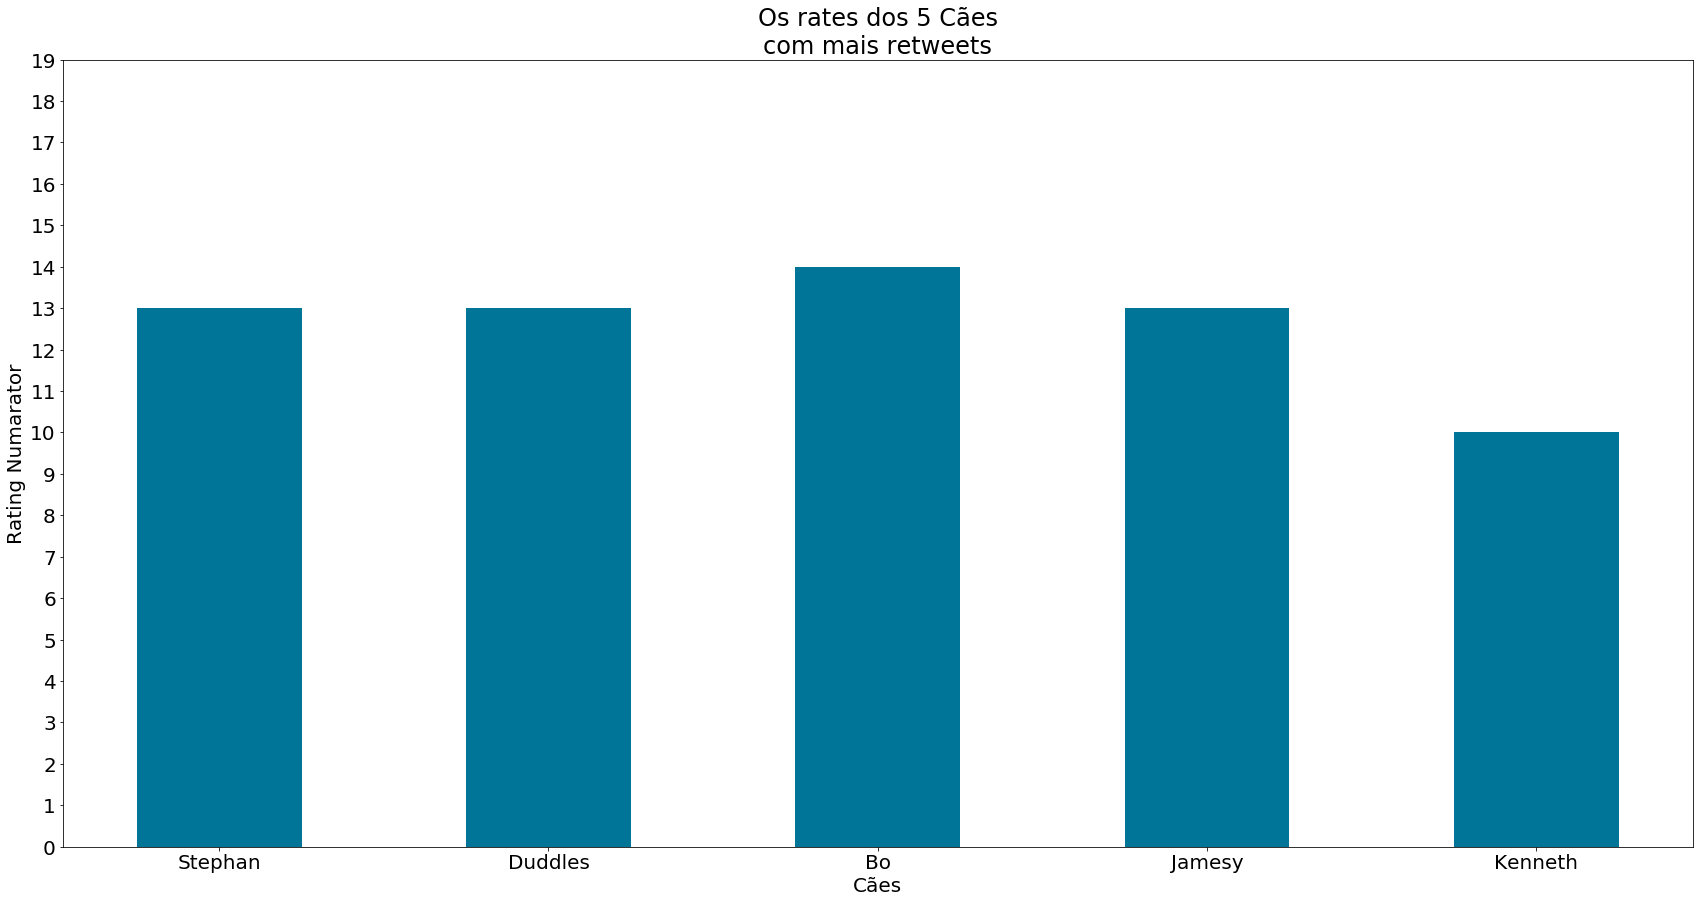

In [108]:
# Cria o gráfico
groups = 5
fig, ax = plt.subplots(figsize=(24, 12))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 1

# Plota gráfico 2
plt.rcParams['font.size'] = 20
plt.title('Os rates dos 5 Cães\ncom mais retweets')
plt.xlabel('Cães')
plt.ylabel('Rating Numarator')
plt.xticks(index, dogs_retweets.name[0:5])
plt.bar(index, dogs_retweets.rating_numerator[0:5], bar_width, alpha=transp, color='#007598')
plt.yticks(np.arange(0, 20, 1))

plt.show();

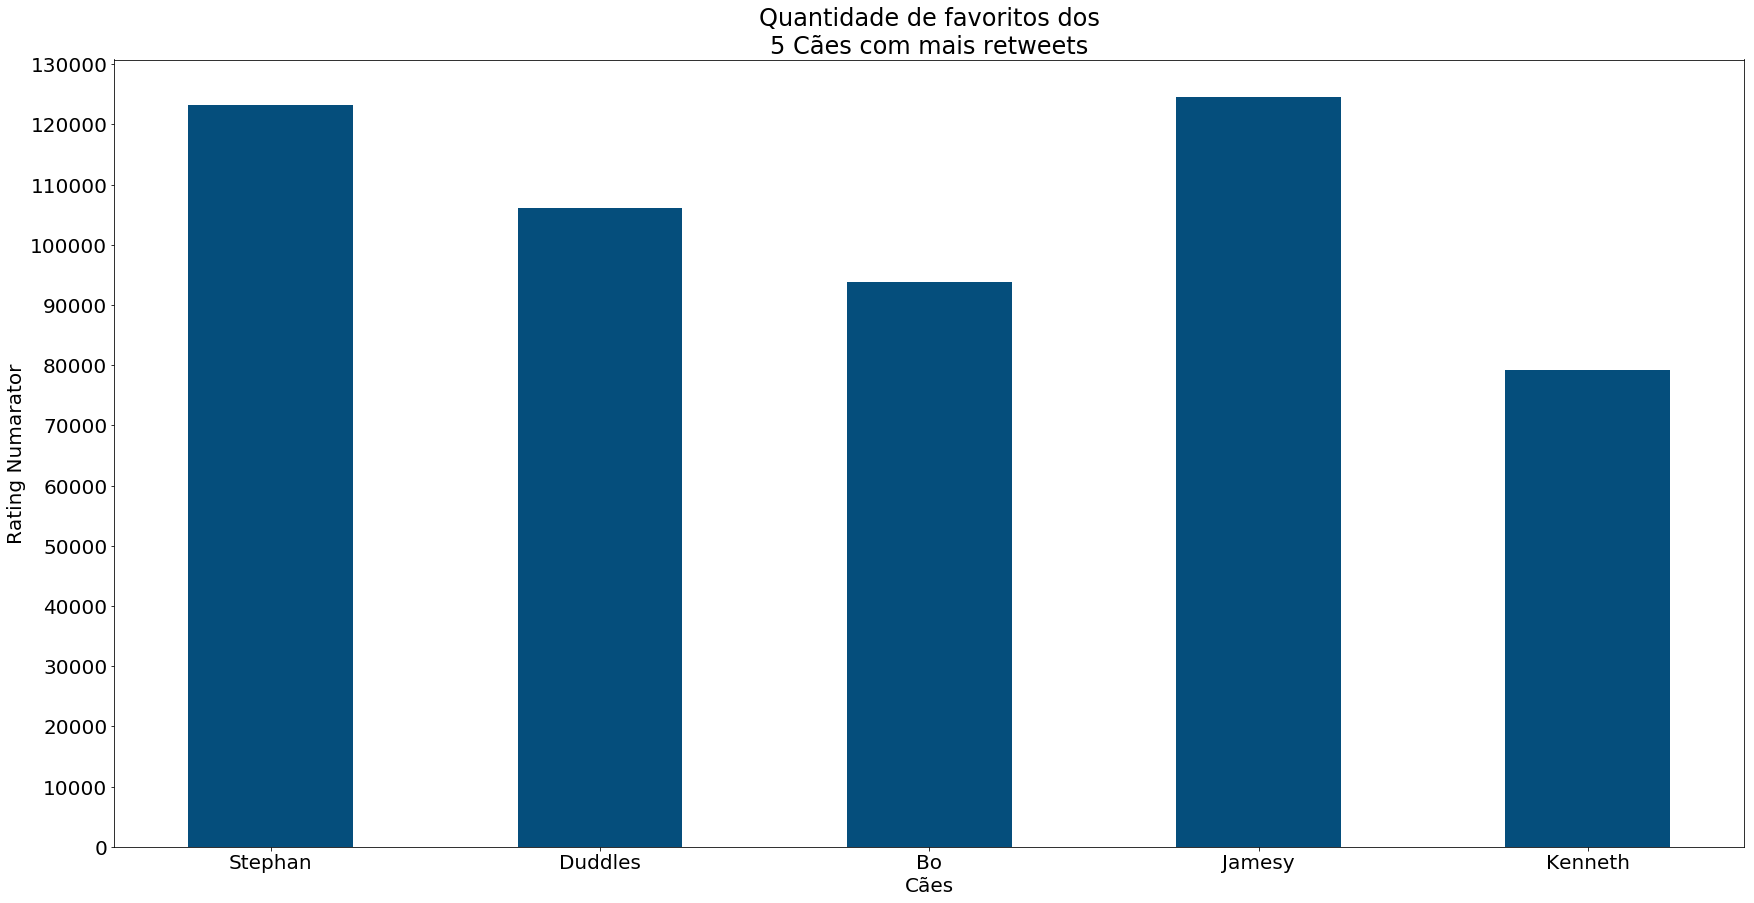

In [109]:
# Cria o gráfico
groups = 5
fig, ax = plt.subplots(figsize=(24, 12))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 1

# Plota gráfico
plt.rcParams['font.size'] = 20
plt.title('Quantidade de favoritos dos\n5 Cães com mais retweets')
plt.xlabel('Cães')
plt.ylabel('Rating Numarator')
plt.xticks(index, dogs_retweets.name[0:5])
plt.bar(index, dogs_retweets.favorite_count[0:5], bar_width, alpha=transp, color='#054e7c')
plt.yticks(np.arange(0, 140000, 10000))

plt.show();

- Adicionalmente foi verificada, através de gráficos de dispersão, a correlação entre retweets, marcação como favorito e os rates do WeRateDogs.

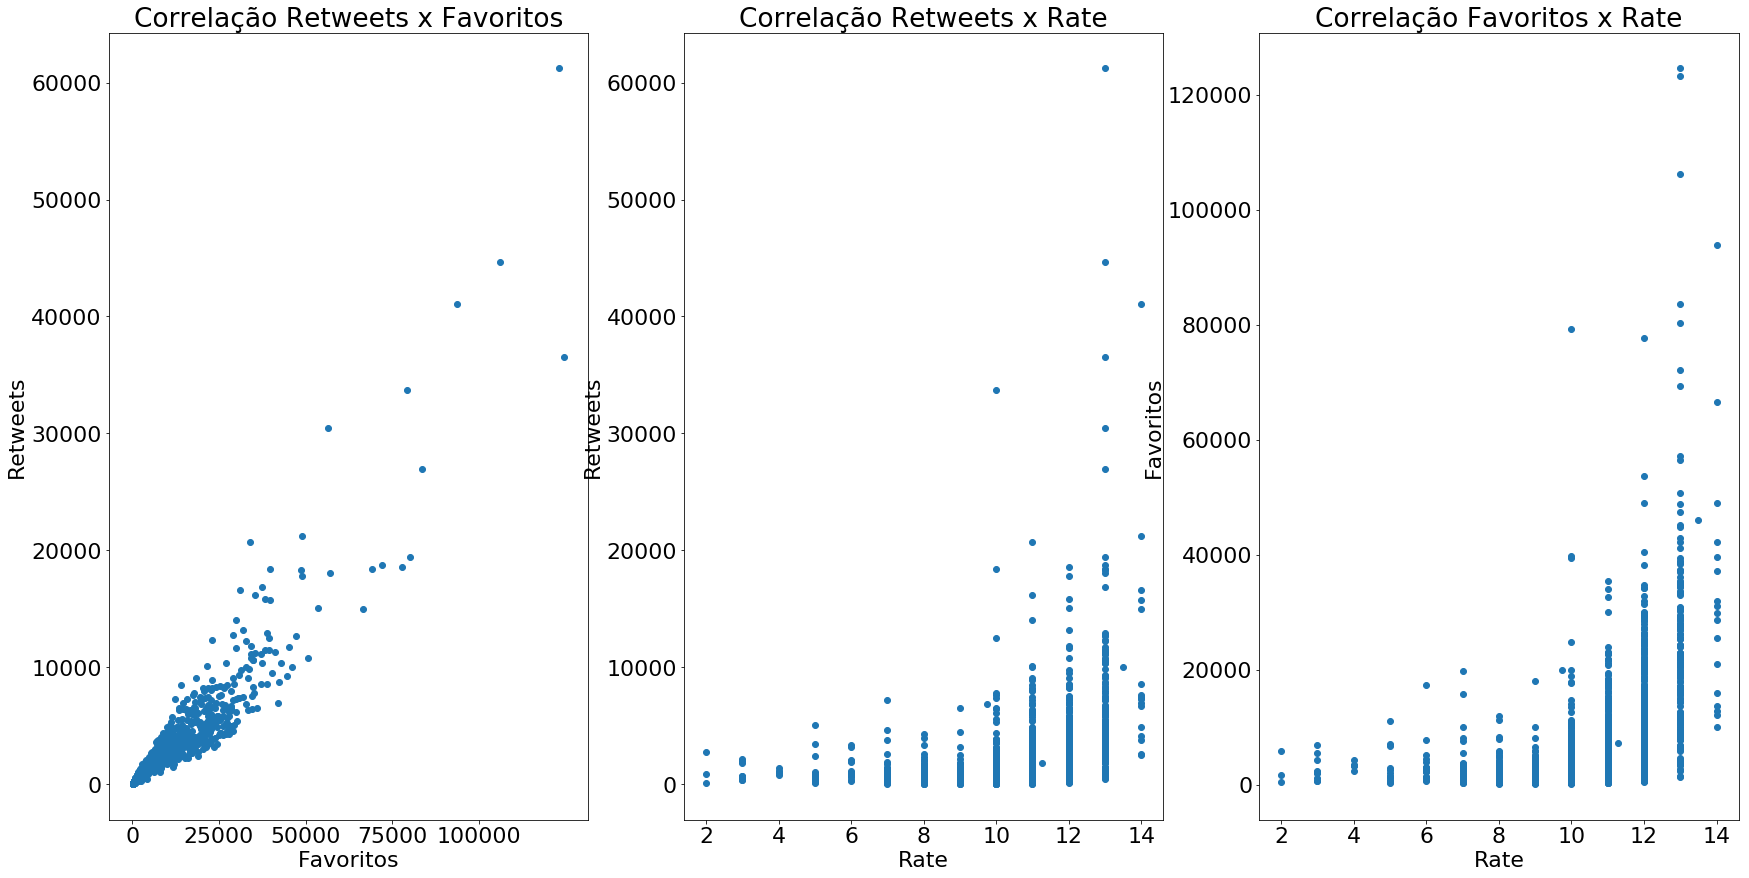

In [110]:
# Cria a gráfico
groups = 5
fig, ax = plt.subplots(figsize=(24, 12))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 1
plt.rcParams['font.size'] = 22
plt.subplot(1, 3, 1)
plt.title('Correlação Retweets x Favoritos')
plt.xlabel('Favoritos')
plt.ylabel('Retweets')
plt.xticks(np.arange(0, 125000, 25000))
plt.scatter(dogs_retweets.favorite_count, dogs_retweets.retweet_count)

plt.subplot(1, 3, 2)
plt.title('Correlação Retweets x Rate')
plt.xlabel('Rate')
plt.ylabel('Retweets')
plt.scatter(dogs_retweets.query('rating_numerator <= 20').rating_numerator, dogs_retweets.query('rating_numerator <= 20').retweet_count)

plt.subplot(1, 3, 3)
plt.title('Correlação Favoritos x Rate')
plt.xlabel('Rate')
plt.ylabel('Favoritos')
plt.scatter(dogs_retweets.query('rating_numerator <= 20').rating_numerator, dogs_retweets.query('rating_numerator <= 20').favorite_count)
plt.show()

**Resposta:**

Os dados parecem indicar que os 5 cães que tiveram mais retweets em suas postagens foram Stephan, Duddies, Bo Jamesy e Kenneth. É interessante que, embora Stephan apareça com mais retweets, ele aparece com o rate de WeRateDogs e marcações de favorito menores que outros cães. No entanto, Jamesy que aparece na quarta posição em retweets, com o mesmo rate de Stephan e mas com um total de marcações de favorito maior.  
Ao comparar retweets, marcação como favorito e os rates do WeRateDogs de todos os cães observou-se uma correlação positiva entre retweets e favoritos.

---

### Questão 2
**Qual a distribuição dos cães segundo os estágios propostos pelo WeRateDogs?**

- Foram filtrados os cães em que o estágio não está disponível.
- Agrupando por estágio, contou-se as ocorrências, que foram então ordenadas descendentemente. Reultando em uma série.

In [111]:
# Faz uma seleção de dados
dog_stage = df.query('dog_stage != "None"').groupby(['dog_stage'])['dog_stage'].count().sort_values(ascending = False)
dog_stage

dog_stage
pupper           203
doggo             63
puppo             22
doggo,pupper       9
floofer            7
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

- Com o resultado foi plotado o gráfico abaixo.

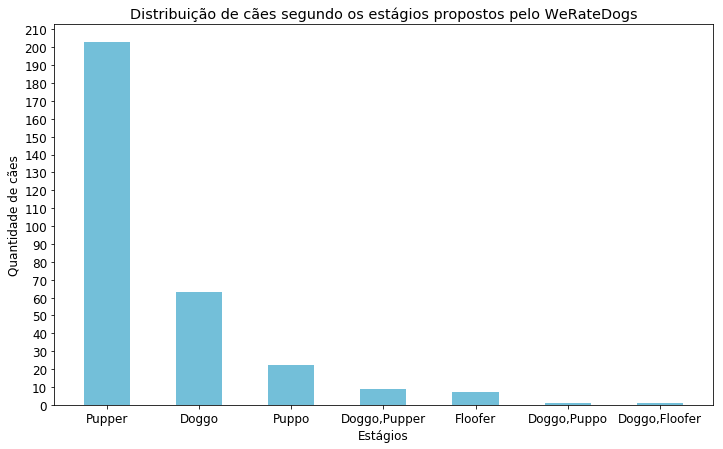

In [125]:
# Cria o gráfico
groups = 7
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 0.7
stages = []
for s in range(0,len(dog_stage)):
    stages.append(dog_stage.index[s].title())

# Plota gráfico

plt.rcParams['font.size'] = 12
plt.tight_layout()
plt.title('Distribuição de cães segundo os estágios propostos pelo WeRateDogs')
plt.xlabel('Estágios')
plt.ylabel('Quantidade de cães')
plt.xticks(index, stages[0:7])
plt.bar(index, dog_stage[0:7], bar_width, alpha=transp, color='#38a4c9')
plt.yticks(np.arange(0, 215, 10))

plt.show();

**Resposta:**


A distribuição dos cães de acordo com os estágios propostos pelo WeRateDogs sugere que a maioria dos cães são "Pupper".

---

### Questão 3
**A raça dos cães parece ter alguma relação com o compartilhamento dos tweets?**

- Foram filtrados valores em que certeza de predição de raça estão abaixo de 0.90 (90%) e os de raça indefinida.
- Agrupados os valores por raça, foram somados retweets e ordenados ascendentemente.
- Também foi contada a quantidade de tweets por raça.

In [114]:
# Faz uma seleção de dados
breed_retweets = df.query('reliability_01 > 0.90 and breed_prediction_01 != "indefinite"' ).groupby(['breed_prediction_01'])['retweet_count'].sum().sort_values(ascending = False)

In [115]:
# Faz uma seleção de dados
breed_tweets = df.query('reliability_01 > 0.90 and breed_prediction_01 != "indefinite"' ).groupby(['breed_prediction_01'])['tweet_id'].count().sort_values(ascending = False)

In [116]:
breed_retweets

breed_prediction_01
Golden Retriever                  139894
Pembroke                          120209
Samoyed                           104227
Labrador Retriever                 93463
French Bulldog                     70437
Pug                                48927
Pomeranian                         42203
Chihuahua                          25259
Chow                               22231
Shetland Sheepdog                  17658
Vizsla                             11307
Blenheim Spaniel                    9786
American Staffordshire Terrier      9321
Toy Poodle                          9301
Brittany Spaniel                    8015
Leonberg                            7208
Basset                              6764
Komondor                            6072
Bernese Mountain Dog                5894
German Shepherd                     5660
Schipperke                          5612
Weimaraner                          5413
Tibetan Mastiff                     5356
Great Pyrenees                      5

In [117]:
breed_tweets

breed_prediction_01
Golden Retriever                  36
Pembroke                          26
Pug                               24
Samoyed                           21
Labrador Retriever                17
Pomeranian                        16
Chihuahua                         13
French Bulldog                    12
Chow                               9
Blenheim Spaniel                   6
Toy Poodle                         5
American Staffordshire Terrier     4
Bernese Mountain Dog               4
Shetland Sheepdog                  4
Brittany Spaniel                   4
German Shepherd                    4
Vizsla                             4
Shih-Tzu                           4
Boston Bull                        3
Komondor                           3
Malamute                           3
Basset                             3
Beagle                             3
Old English Sheepdog               3
Pekinese                           3
Rottweiler                         3
Cocker Spaniel    

- Com as quantidades de tweets e retweets de cada raça, plotou-se o gráfico abaixo.

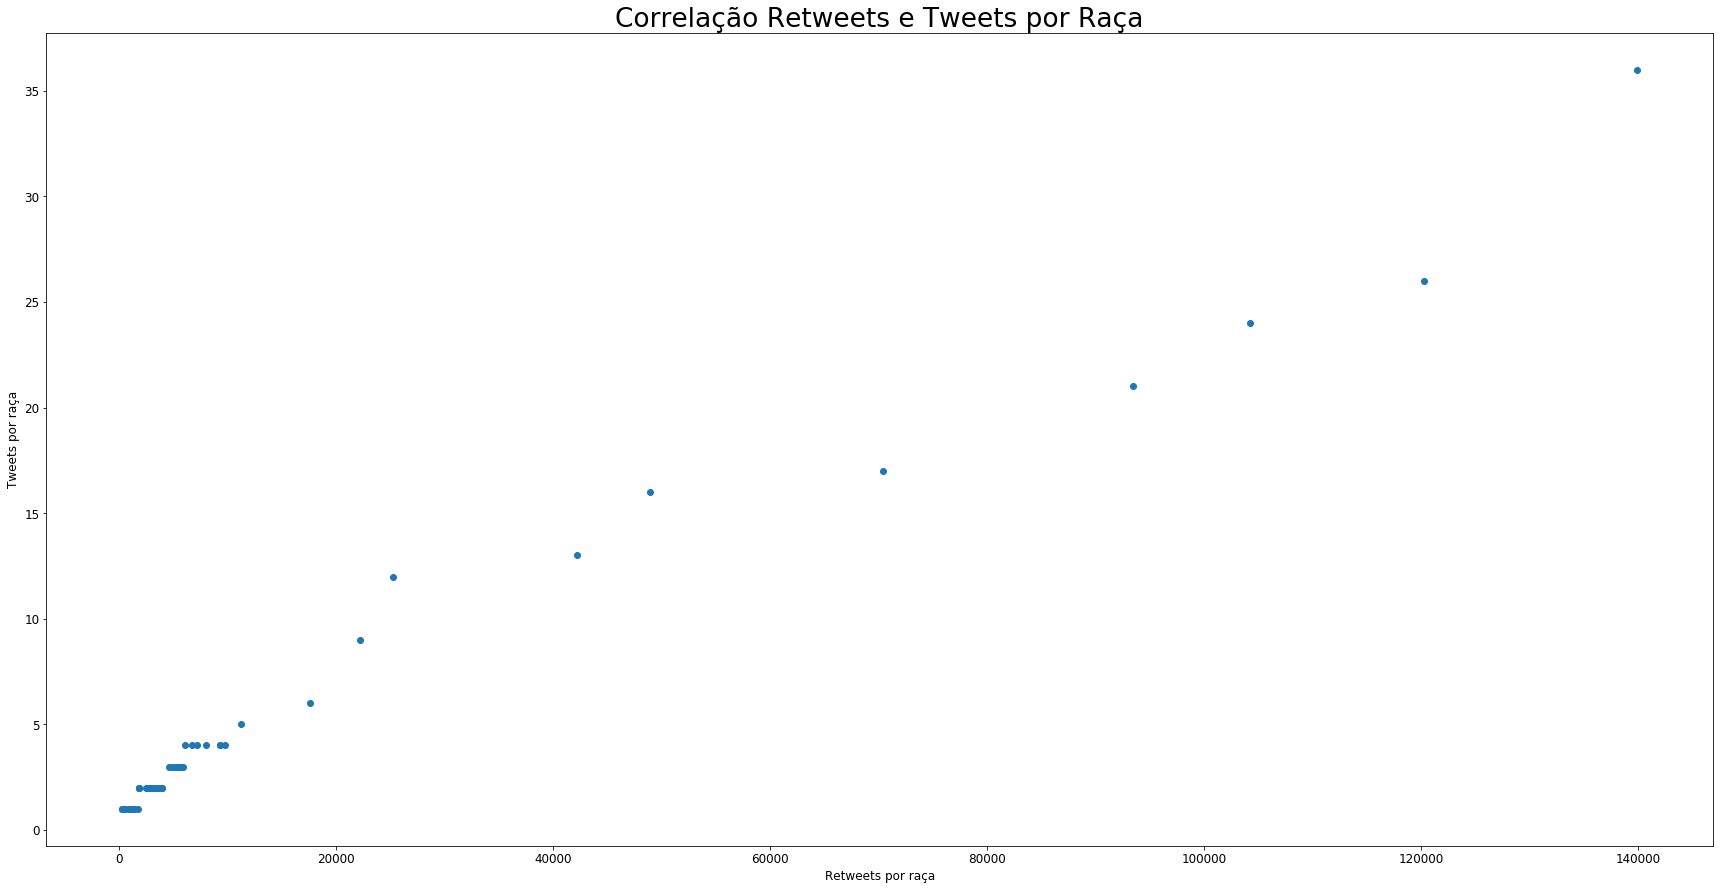

In [118]:
# Cria o gráfico
groups = 5
fig, ax = plt.subplots(figsize=(24, 12))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 1
plt.rcParams['font.size'] = 22
plt.title('Correlação Retweets e Tweets por Raça')
plt.xlabel('Retweets por raça')
plt.ylabel('Tweets por raça')
plt.scatter(breed_retweets, breed_tweets)
plt.show()

**Resposta:**


Os dados apontam um maior número de retweets para raça Golden Retriever. Porém os dados também apontam que é a raça que mais tem postagem no WeRateDogs. 
Através do gráfico de dispersão percebe-se uma correlação positiva entre a quantidade de tweets e retweets. Ou seja, sem indicação de muitos retweets para uma raça que tenha tido poucos tweets.

---

### Questão 4
**Há muitos cães com o mesmo nome? Se sim, quais 10 os nomes mais comuns?**

In [119]:
# Faz uma seleção de dados
df.query('name != "None"').name.value_counts()[0:10]

Charlie    11
Oliver     10
Cooper     10
Lucy       10
Penny       9
Tucker      9
Sadie       8
Winston     8
Lola        7
Daisy       7
Name: name, dtype: int64

**Resposta:**

Há muitos cães com o mesmo nome. Os 10 nomes mais comuns parecem ser: Charlie, Lucy, Oliver, Cooper, Tucker, Penny, Sadie, Winston, Lola e Toby.

---

### Questão 5
**O estágio do cão sugere alguma relação com a classificação dada pelo WeRateDogs?**

- Foram filtradas as linha o estágio do caõ, 'dog_stage', não está disponível e gerada uma série com o estágio e a classificação 'rating_numerator'.

In [120]:
# Filtra e gera série com 'dog_stage' e 'rating_numerator'
stage_rate = df.loc[df.dog_stage != "None", ['dog_stage','rating_numerator']]

In [121]:
# Faz uma seleção de dados por média
stages_rate_mean = stage_rate.groupby('dog_stage')['rating_numerator'].mean()

- Com a série foi plotado o gráfico abaixo.

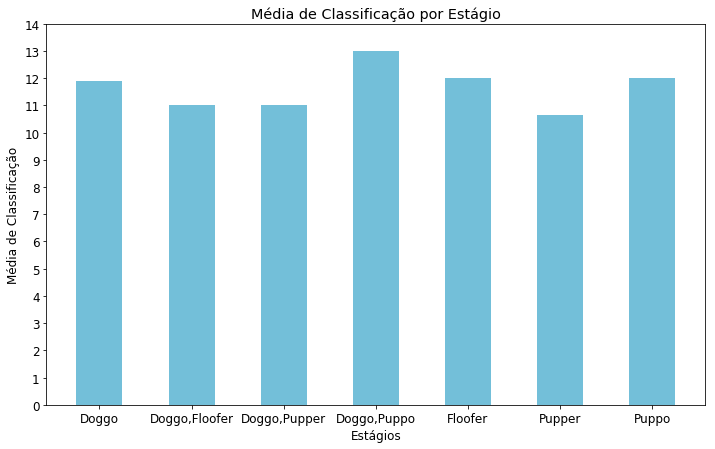

In [123]:
# Cria o gráfico
groups = 7
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout()
index = np.arange(groups)
bar_width = 0.5
transp = 0.7
stages = []
for s in range(0,len(stages_rate_mean)):
    stages.append(stages_rate_mean.index[s].title())

# Plota gráfico

plt.rcParams['font.size'] = 12
plt.tight_layout()
plt.title('Média de Classificação por Estágio')
plt.xlabel('Estágios')
plt.ylabel('Média de Classificação')
plt.xticks(index, stages[0:7])
plt.bar(index, stages_rate_mean[0:7], bar_width, alpha=transp, color='#38a4c9')
plt.yticks(np.arange(0, 15, 1))

plt.show();

**Resposta:**


Considerando que na Questão 2 os dados apontam que a maioria dos cães estão indicados como 'Pupper'. Aparentemete cães neste estágio recebem uma classificação menor que os demais.

---

### Conclusão

De acordo com os dados os 5 cães que tiveram mais retweets em suas postagens foram Stephan, Duddies, Bo Jamesy e Kenneth, observou-se que cães com maior rate parecem receber mais retweets.  
A maioria dos cães parece ser "Pupper" e a raça que mais teve retweets foi a Golden Retriever, que é também a raça que aparece com o maior de postagens. De uma maneira geral os gráficos não parecem indicar nenhuma raça que tenha poucas postagens, mas com número de tweets por postagem desproporcional.  
Os nomes de cães mais comuns parecem ser: Charlie, Lucy, Oliver, Cooper, Tucker, Penny, Sadie, Winston, Lola e Toby.
E aparentemete cães no estágio "Pupper" recebem uma classificação menor que os demais.  

Um filhote de cão Golden Retriever, com nome 'Charlie' provavelmente fará muito sucesso, terá um ótimo rate, muitos retweets e marcações como favorito.

**Limitações**

Algumas das respostas tiveram limitações devido a dados indisponíveis por diversos fatores. Desta forma esta análise remete-se apenas os conteúdo parcialmente apurado através das postagens do WeRateDogs.

**Fontes de consulta**

- Udacity - https://br.udacity.com/course/fundamentos-data-science-ii--nd111 
- WeRateDogs - https://twitter.com/dog_rates
- Tweepy - http://www.tweepy.org/
- Twitter API - https://developer.twitter.com
- Slick Remix - https://www.slickremix.com
- Stack Overflow - https://stackoverflow.com/
- American Kennel Club - https://www.akc.org/
- Kaggle - https://www.kaggle.com/